# This notebook is used to run the python code through Jupyter as if it was a command line. So we run python files, and can use commands such as mpirun to run stuff in parallel.
# Need to put a '!' in front of every command meant for the command line

In [1]:
from dolfin import *

#Increasing the width of the notebook (visual difference only)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#importing mshr for all mesh functions
import mshr as mshr

#have to define where to put plots BEFORE importing matplotlib
%matplotlib notebook

#Importing matplotlib to plot the results
from matplotlib import pyplot as plt

#Importing numpy to work with arrays
import numpy as np

#Importing time to compute how long each segment takes
import time

#Needed to use the 3D scatter
from mpl_toolkits.mplot3d import Axes3D

#Importing all quantities, constants etc used in the calculations
from MONDquantities import *

#Importing all classes I created
from MONDclasses import *

#Importing the functions I made from the MONDfunctions file
from MONDfunctions import *

#Importing all expressions for weak forms, initial guesses/BCs and sources
from MONDexpressions import *

In [2]:
#Very nice link tutorial for MPI with Python:
#https://rabernat.github.io/research_computing/parallel-programming-with-mpi-for-python.html

#Full MPI documentation for Python:
#https://mpi4py.readthedocs.io/en/stable/

#Creating a group in MPI only including certain processes. Kees said the even ones are the cores, the
#odd ones the other thread available per core, so would be nice to get a communicator of cores only!

#IMPORTANT: It turn out that the error coming from using too much memory doesnt seem to happen when using
#MPI! This error: 'PETSc error code is: 76' This means we can use bigger, better meshes and not be
#limited by memory if we run in parallel

#Converting the notebook to a runnable python file 
!jupyter nbconvert --to script MONDtest_NoFunctions_MPI.ipynb

[NbConvertApp] Converting notebook MONDtest_NoFunctions_MPI.ipynb to script
[NbConvertApp] Writing 51510 bytes to MONDtest_NoFunctions_MPI.py


In [3]:
#Running the full script in parallel using MPI. Optimal number of processes:8. This includes two threads
#per core.
! mpirun -n 8 python3 MONDtest_NoFunctions_MPI.py

#IMPORTANT: when solving for newton_continuous, if we have dregee_PDE = 3 it solves OK.
#However, if we have degree_PDE = 1 we get the error:
#ValueError: zero-size array to reduction operation maximum which has no identity for the 3D plots!

Process 0: Generating mesh with CGAL 3D mesh generator
Process 0: Computed global bounding box tree with 15 boxes.Process 1: Computed global bounding box tree with 15 boxes.
Process 2: Computed global bounding box tree with 15 boxes.
Process 3: Computed global bounding box tree with 15 boxes.
Process 4: Computed global bounding box tree with 15 boxes.
Process 5: Computed global bounding box tree with 15 boxes.
Process 6: Computed global bounding box tree with 15 boxes.
Process 7: Computed global bounding box tree with 15 boxes.

Process 0: Computed global bounding box tree with 15 boxes.
Process 1: Computed global bounding box tree with 15 boxes.
Process 2: Computed global bounding box tree with 15 boxes.
Process 3: Computed global bounding box tree with 15 boxes.
Process 4: Computed global bounding box tree with 15 boxes.
Process 5: Computed global bounding box tree with 15 boxes.
Process 6: Computed global bounding box tree with 15 boxes.
Process 7: Computed global bounding box tree 

MONDtest_NoFunctions_MPI.py:1035: RuntimeWarning: divide by zero encountered in true_divide
  acceleration_error = np.abs((acceleration_magnitude_sorted - acceleration_dirac_analytic)/acceleration_magnitude_sorted)
MONDtest_NoFunctions_MPI.py:1035: RuntimeWarning: divide by zero encountered in true_divide
  acceleration_error = np.abs((acceleration_magnitude_sorted - acceleration_dirac_analytic)/acceleration_magnitude_sorted)
This is process 6 out of 7
Starting mesh generation...

Mesh generated in 2.7525901794433594 s 

The mesh of process 6 has 2777 cells
Process 6 about to refine
Starting mesh refinement...

Iteration 1 of 10: The Cell number went from 2777 to 2624, up by a factor 0.9449045732805186

Iteration 2 of 10: The Cell number went from 2624 to 2686, up by a factor 1.0236280487804879

Iteration 3 of 10: The Cell number went from 2686 to 2888, up by a factor 1.075204765450484

Iteration 4 of 10: The Cell number went from 2888 to 2832, up by a factor 0.9806094182825484

Iterat

In [4]:
#Creating a folder for each set of parameters we use.

x_total_sorted = np.load('Numpy_Arrays/x_sorted_saved.npy')
y_total_sorted = np.load('Numpy_Arrays/y_sorted_saved.npy')
z_total_sorted = np.load('Numpy_Arrays/z_sorted_saved.npy')
r_total_sorted = np.load('Numpy_Arrays/r_sorted_saved.npy')
potential_total_sorted = np.load('Numpy_Arrays/potential_saved.npy')
source_total_sorted = np.load('Numpy_Arrays/source_saved.npy')
apparent_mass_total_sorted = np.load('Numpy_Arrays/apparent_mass_saved.npy')
dark_mass_total_sorted = np.load('Numpy_Arrays/dark_mass_saved.npy')

<IPython.core.display.Javascript object>


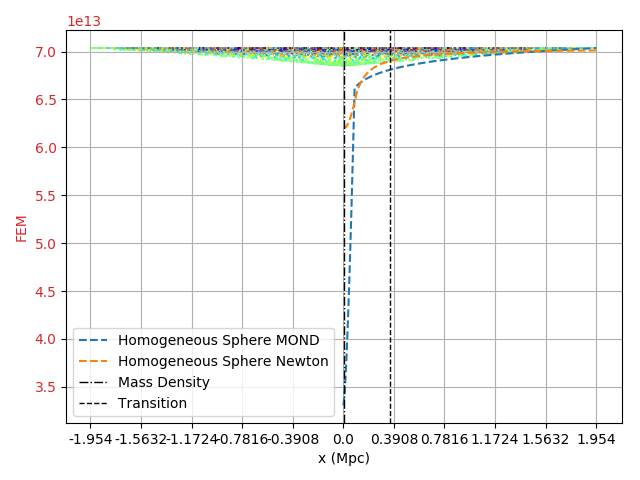

In [5]:
#Defining the radius of the Gaussian containing 99.7% of the total mass
radius_tot = stand_dev_peak/3

#Analytic potential for a MOND homogeneous sphere (good approximation to Gaussian, peaked or wide)
potential_dirac_MOND= sqrt(G*mgb*a0)*np.log(r_total_sorted)

#Analytic potential for a MOND homogeneous sphere. Adding MOND potential at boundary for the offset
potential_sphere_MOND = (np.heaviside(r_total_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*np.log(r_total_sorted) +
(np.heaviside(radius_tot - r_total_sorted, 0.5))*(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*np.power(r_total_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*radius_tot**(3/2)))

#Potential for a homogeneous sphere in Newton
potential_sphere_Newton = (np.heaviside(r_total_sorted - radius_tot, 0.5)*(-G*mgb/r_total_sorted) +
(np.heaviside(radius_tot - r_total_sorted, 0.5))*G*mgb/(2*radius_tot**3)*(r_total_sorted**2-
3*radius_tot**2)+sqrt(G*mgb*a0)*ln(domain_size))

#Plotting radial FEM solution and analytic solution on the same plot. We use subplots so'
#we can put multiple axes on the same plot and plot different scales
fig, potential1 = plt.subplots(sharex=True, sharey=True)

color = 'tab:red'
potential1.set_ylabel('FEM', color=color)

potential1.scatter(x_total_sorted, potential_total_sorted, marker = '.', s = 0.5, c = y_total_sorted/y_total_sorted.max(), cmap = 'jet')

potential1.tick_params(axis='y', labelcolor=color)

#UNCOMMENT TO HAVE SEPARATE AXES TO COMPARE SHAPES
# potential2 = potential1.twinx()
color = 'tab:blue'
# potential2.set_ylabel('Analytic', color=color)
plt.plot(r_total_sorted, potential_sphere_MOND, label = 'Homogeneous Sphere MOND', linestyle = '--')
plt.plot(r_total_sorted, potential_sphere_Newton, label = 'Homogeneous Sphere Newton', linestyle = '--')

#It is possible to use Latex directly in the labels by enclosing expressions in $$
# plt.ylabel('$\phi$')

plot_annotations(potential1)

#Formatting plot using the function I made
plot_format(potential1,1,0)

potential1_title = f'potential_1_p'

#Saving the figure in the Figure folder, removed padding arounf with bbox_inches and. This is executed
#by each process, so uncomment if need to see solution from each process separately
# plt.savefig(f'Figures/{potential1_title}.pdf', bbox_inches='tight')


In [6]:
mgb/(4*pi/3*domain_size**3)

2.447731038318541e-25

<IPython.core.display.Javascript object>


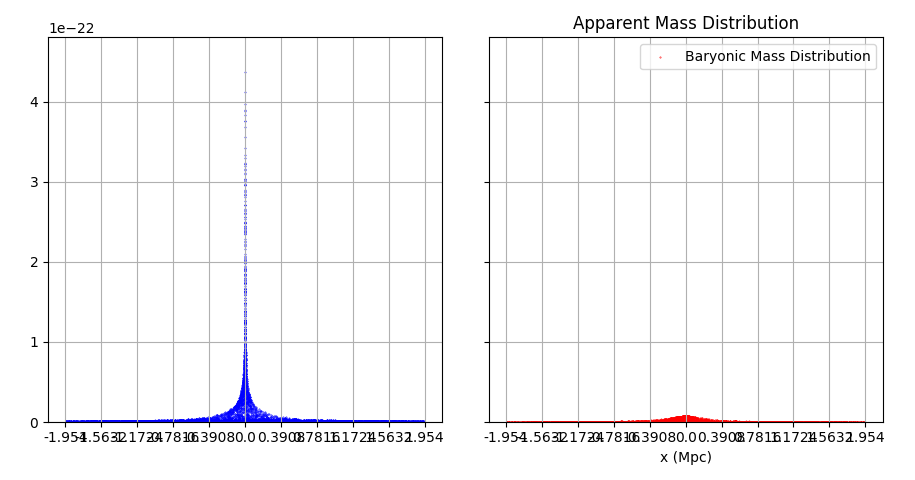

The mass should be: 1.13MS. It is 6.569156082723931MS
The ratio of the integrated masses are:
 baryonic integrated/correct mass: 5.81341246258755. This should be 1 
Dark mass/baryonic mass = 0.0
Dark mass/ baryonic integrated = 0.0


In [7]:
fig, apparent_mass_plot = plt.subplots(1,2,sharex=True,sharey=True)

apparent_mass_ylim = (1.1*apparent_mass_total_sorted.min(), 1.1*apparent_mass_total_sorted.max())

plot_together = True

#Scaling the mass distribution by 4*pi*G to get rho itself
apparent_mass_plot[0].scatter(x_total_sorted, apparent_mass_total_sorted,  marker = '.', s = 0.5, c = 'b', cmap = 'jet', label = 'Apparent Mass Distribution')
 

if plot_together == True:
    
    apparent_mass_plot[1].scatter(x_total_sorted, source_total_sorted,   marker = '.', s = 0.5, c = 'r', cmap = 'jet', label = 'Baryonic Mass Distribution')

#Limits fixed from max and min of the apparent mass density, with 10% free extra space
plt.ylim(1.1*apparent_mass_total_sorted.min(), 1.1*apparent_mass_total_sorted.max())    

plt.title('Apparent Mass Distribution')
# plot_annotations(apparent_mass_plot)
plot_format(apparent_mass_plot[0],1,0)
plot_format(apparent_mass_plot[1],1,0)

#Integrating the baryonic distribution radially
baryonic_mass_integrated = np.trapz(apparent_mass_total_sorted*4*pi*r_total_sorted**2, x = r_total_sorted)

#Calculating the total mass by integrating the distribution radially
apparent_mass_integrated = np.trapz(apparent_mass_total_sorted*4*pi*r_total_sorted**2, x = r_total_sorted)

#The total dark matter is given by the difference of apparent and baryonic masses
dark_mass_integrated = apparent_mass_integrated - baryonic_mass_integrated

#Ratio between the integrated baryonic density and the total mass. Should be 1
baryonic_integrated_ratio = baryonic_mass_integrated/mgb

#Ratio between the dark matter and the total mass
dark_integrated_ratio = dark_mass_integrated/mgb

#Ratio between the dark matter and baryonic matter, should be exact same as dark_intergrated_ratio!
dark_baryonic_ratio = dark_mass_integrated/baryonic_mass_integrated

print(f'The mass should be: {mgb/(10**14*ms)}MS. It is {baryonic_mass_integrated/(10**14*ms)}MS\nThe ratio of the integrated masses are:\n baryonic integrated/'
      f'correct mass: {baryonic_integrated_ratio}. This should be 1 \n'
      f'Dark mass/baryonic mass = {dark_integrated_ratio}\n'
      f'Dark mass/ baryonic integrated = {dark_baryonic_ratio}')

<IPython.core.display.Javascript object>


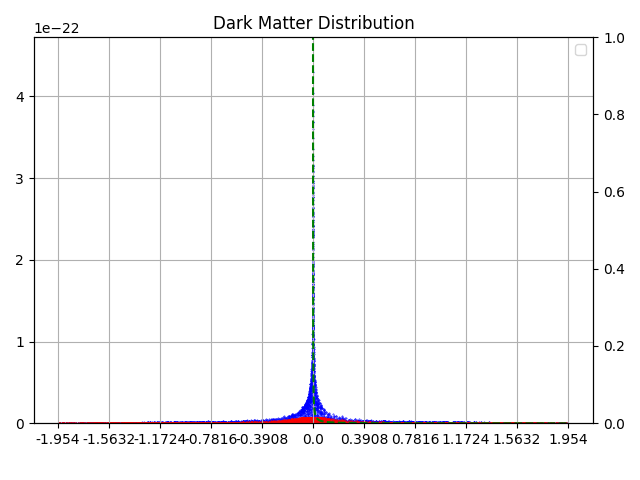

No handles with labels found to put in legend.


In [10]:
#Declaring the parameters needed for the Navarro Frenk White distribution
#The density scale
rho_0 = rho_0

#The scale radius
R_s = domain_size

#Analytical formula for the Navarro Frenk White distribution
NFW_distribution = rho_0/((r_total_sorted/R_s)*(1 + r_total_sorted/R_s)**2)

#The difference between apparent mass and baryonic mass is the dark matter distribution
dark_matter_total_sorted = (apparent_mass_total_sorted-source_total_sorted)

fig, dark_matter_density_plot = plt.subplots()

dark_matter_density_plot.scatter(x_total_sorted, dark_matter_total_sorted,  marker = '.', s = 0.5, c = 'b', cmap = 'jet', label = 'Dark Matter Distribution')

#Limits fixed from max and min of the apparent mass density, with 10% free extra space
plt.ylim(1.1*dark_matter_total_sorted.min(), 1.1*dark_matter_total_sorted.max())    

#Plotting a Navarro Frenk White dark matter distribution on the same graph but not same axis, so it's
#scale independent
NFW_profile_plot = dark_matter_density_plot.twinx()
color = 'tab:blue'

dark_matter_density_plot.plot(r_total_sorted, NFW_distribution, label = 'NFW profile', linestyle = '--', color='g')


if plot_together == True:
    
     dark_matter_density_plot.scatter(x_total_sorted, source_total_sorted,   marker = '.', s = 0.5, c = 'r', cmap = 'jet', label = 'Baryonic Mass Distribution')

plt.title('Dark Matter Distribution')
# plot_annotations(dark_matter_density_plot)
plot_format(dark_matter_density_plot,1,0)